In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from jupyterthemes import jtplot
jtplot.style()

import Functions as fun

Let's get the lines from previous notebook:

In [2]:
lines = fun.import_lines()
main_line = fun.import_main_line()

In [5]:
pd.DataFrame(lines, columns=['x1','y1','x2','y2']).head()

,x1,y1,x2,y2
0,259912.219300,794407.317100,259977.921100,794417.510300
1,259913.139156,794401.388031,259978.840956,794411.581231
2,259914.059012,794395.458961,259979.760812,794405.652161
3,259914.978868,794389.529892,259980.680668,794399.723092
4,259915.898724,794383.600822,259981.600524,794393.794022


In [6]:
main_line

array([[259912.2193    , 794407.3171    ],
       [259938.89512233, 794235.37408472],
       [259906.01353769, 794163.48315452],
       [259908.77310552, 794145.69594605]])

Let's plot everything:

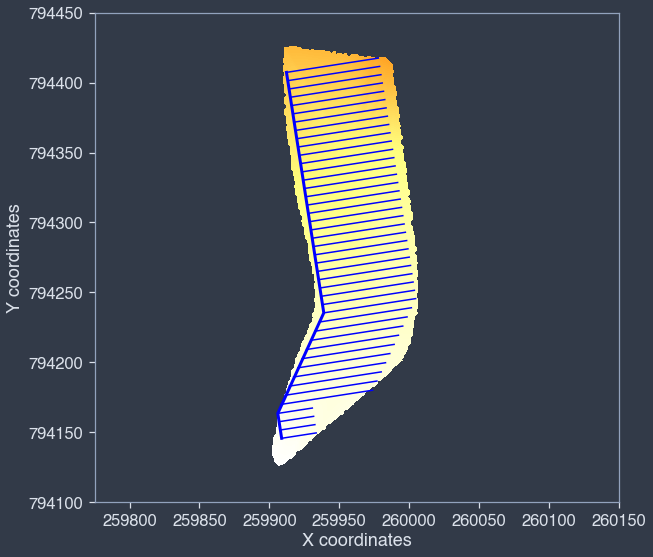

In [10]:
fun.plot_map(False, False) # Plotting map
plt.grid(b=False)

for line in lines: # Plotting drip lines
    line = line.reshape(2,2)
    plt.plot(line[:,0],line[:,1],c='blue')

plt.plot(main_line[:,0],main_line[:,1],c='blue',lw=3) # Plotting main line

The drip line we chose is with the following attributes:

TifDrip (no pressure compensating) 16/1(1.0 mm)
* L = 66 m
* Drip space = 0.4 m $\rightarrow$ 66/0.4 + 1 = 166 emitters.
* D = 0.016 m
* $P_\text{nom} = 3.5 \text{ atm} = 303.975 \text{ kPa} \rightarrow \frac{P_\text{nom}}{\gamma} = 31.018 \text{ m}$
* $C = 140$ (Assuming that the material is polyethylen and according to [this](https://www.engineeringtoolbox.com/hazen-williams-coefficients-d_798.html]))

With the following Flow-Pressure charchteristic:

$\displaystyle F = a\times P^{x}$

Text(0.5, 1.0, 'a = 0.999, x= 0.478')

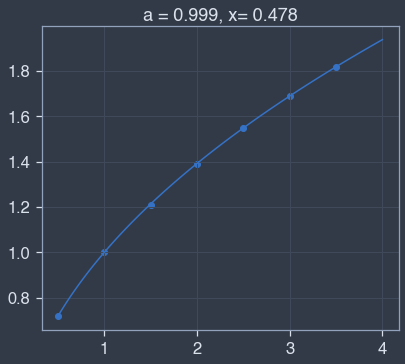

In [71]:
P = np.arange(0.5,4,0.5) # From Naan Catalog [bar]
F = np.array([0.72,1,1.21,1.39,1.55,1.69,1.82]) # From Naan Catalog [l/h]
plt.scatter(P,F)

def drip_flow_obj(parameters):
    a,x = parameters # a constant, x exponent
    return np.sum((a * P ** x - F)**2)
from scipy.optimize import minimize
a,x = minimize(drip_flow_obj, (0.5,0.5)).x

pressures = np.linspace(0.5,4,100)

plt.plot(pressures, a * pressures ** x)
plt.title('a = {:.3f}, x= {:.3f}'.format(a,x))

We are aimming to $q_\text{nom}$
Let's calculate the total head loss for this drip line according to:

$\displaystyle hf_L = KD^{-\beta}Q_0^{\alpha}L\frac{1}{\alpha+1}$

In [19]:
line = lines[0].reshape(2,2)

Q0 = 166 * 4.167 * 1e-7 # [m^3 / s]
L = fun.calculate_distance(line) # [m]
C = 140
D = 0.0142 # [m]

alpha = 1.852
beta = 4.87
K = 10.67 / (C ** alpha)

hf = K * (D ** (-beta)) * (Q0 ** alpha) * L * (1/(1+alpha))
hf

0.5188440236066261

Let's plot the profile:

(171.48187898627214, 182.48187898627214)

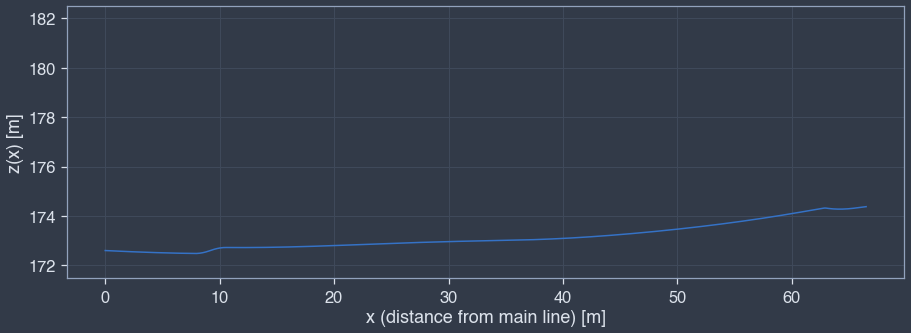

In [27]:
profile = fun.get_profile(line)
x = profile[:,0].flatten()
zx = profile[:,1].flatten()

plt.figure(figsize=(15,5))
plt.plot(x, zx)
plt.xlabel('x (distance from main line) [m]')
plt.ylabel('z(x) [m]')
plt.ylim(min(zx)-1,min(zx) + 10)

Next, we would like to plot the pressure according to:

$\displaystyle \frac{P}{\gamma}(x) =
\frac{P_0}{\gamma} - 
hf_L \left(1-\left(1-\frac{x}{L}\right)^{\alpha+1}\right) +
z_0 -
z(x)
$

If we assume that $\frac{P_0}{\gamma} = \frac{P_\text{nom}}{\gamma} = 31.018 \text{ m}$, then we get:

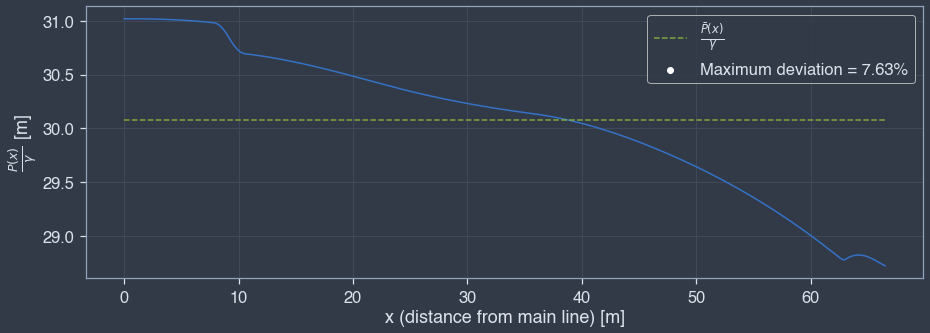

In [34]:
Po_gamma = 31.018
z0 = profile[0,1]


Px_gamma = Po_gamma - hf*(1-(1-x/L)**(alpha+1)) + z0 - zx
Px_gamma_bar = np.mean(Px_gamma) # The mean
max_dev = (max(Px_gamma)-min(Px_gamma))/Px_gamma_bar * 100 # Max deviation [%]

plt.figure(figsize=(15,5))
plt.plot(x , Px_gamma)
plt.plot([0,max(x)],[Px_gamma_bar,Px_gamma_bar],ls='--',label=r'$\frac{\bar{P}(x)}{\gamma}$')
plt.scatter([],[],c='white',label='Maximum deviation = {:.2f}%'.format(max_dev))
plt.xlabel('x (distance from main line) [m]')
plt.ylabel(r'$\frac{P(x)}{\gamma}$ [m]')
plt.legend()

In order to calculate the next drip line we need to count the pressure decrease in the main line and for that we need to attribute out main line:

Let's assume for now:
* $Q = Q_\text{total} - Q_{1}$
* L = 6 m (until the next section)
* C = 140
* D = 0.083

Note that 
* N = 6292
* $Q_\text{total} = N \times 4.167\times10^{-7} \frac{m^3}{s}$
* $Q_1 = 165 \times 4.167\times10^{-7} \frac{m^3}{s}$

That means head loss of:

$\displaystyle hf = L \left(\frac{Q}{C}\right)^\alpha\frac{10.67}{D^\beta}$

In [36]:
N=6292
Q1 = 165 * 4.167 * 1e-7
Q_total = N * 4.167 * 1e-7
Q = Q_total - Q1
D = 0.083
main_hf = 6 * ((Q/C)**alpha) * (10.67 / (D**beta))
main_hf

0.019664025787659602

So now we need to do the same calculation from the next line with

$\displaystyle \frac{P_0}{\gamma} = 31.018 - 0.01966 \text{ m}$

This is our core of the algorithm the calculate the pressure along all of the system.

## Calculating System Pressure

For each drip line:
* Setting the length - L.
* Setting the numbers of emitters - N_e
* Setting the initial pressure P0_gamma
* 


In [37]:
100000/9800

10.204081632653061